In [248]:
import copy
import os
import re
import shutil
import sys
from pathlib import Path

import numpy as np
import tifffile
import yaml
from einops import rearrange

In [37]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
%autoreload 2

In [81]:
import mushroom.data.multiplex as multiplex
import mushroom.data.visium as visium
import mushroom.data.xenium as xenium
import mushroom.data.cosmx as cosmx
import mushroom.data.he as he
import mushroom.registration.bigwarp as bigwarp
import mushroom.utils as utils

## Defining inputs

defining run directory and specifying scale factor for registration

In [278]:
run_dir = '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/examples/full_workflow'
reg_dir = os.path.join(run_dir, 'registration')
Path(reg_dir).mkdir(parents=True, exist_ok=True)

Defining data map that specifies data types and locations for data used in serial section experiment

Data map is a dictionary where each key is a sample identifier that maps to information about data for that sample.

The data are specified as the following:
 + order - Specifies order of sections in experiment
 + target_section - Section ID of initial target section used during registration. This section is important because it determines what the resolution of all the registered sections will be.
 + data - Dictionary mapping data type to sections present for that data type
   + Dictionary keys are data types. Valid data types are ('multiplex', 'he', 'xenium', 'cosmx', 'visium', 'points'), or strings that end in "_{dtype}" where {dtype} is one of the valid data types. Please check []() to ensure that your data is specified correctly and for more information on data types and their specifications. If your data type cannot be read in, consider formatting it as user-defined "multiplex" or "points" data according to the tutorial here []().
   + Dictionary values are dictionaries where the key is a section_id, and the value is the filepath to data for the given section. section_id must match section IDs specified in "order". For more information on what inputs are valid for different data types see []().
   
Note that the same section can have multiple data types. If this is the case, all data types for that section must be at the same resolution. For example, for visium data that has expression and H&E, the H&E image must be at the same level of resolution as the spot coordinates.

In [296]:
data_map = {
    'target_sid': 'S18-9906-U2',
    'resolution': None, # we will calculate in slide below, but if you know up front you can just specify here
    'sections': [
        {
            'sid': 'S18-9906-U1',
            'position': 0,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/S18-9906/B27Us1_1/S18-9906-B27Us1_1Bp1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/sandbox/S18-9906_U1_tmp.tif'
                },
            ] 
        },
        {
            'sid': 'S18-9906-U2',
            'position': 5,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20230912__220334__24002/output-XETG00122__0010784__S18-9906-B27Us1_2Q1__20230912__220421'
                },
            ] 
        },
        {
            'sid': 'S18-9906-U3',
            'position': 10,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231006_Prostate_Serial_S18-9906_slide_3/S18-9906-U3__20231006.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'S18-9906-U9',
            'position': 40,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20230912__220334__24002/output-XETG00122__0010787__S18-9906-B27Us1_9Q1__20230912__220421'
                },
            ] 
        },
        {
            'sid': 'S18-9906-U10',
            'position': 45,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231006_Prostate_Serial_S18-9906_slide_3/S18-9906-U10__20231006.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'S18-9906-U16',
            'position': 105,
            'data': [
                {
                    'dtype': 'visium',
                    'filepath': '/diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/S18-9906/B27Us1_16/S18-9906-B27Us1_16Bp1/outs'
                },
                {
                    'dtype': 'he',
                    'filepath': '/diskmnt/Projects/Users/estorrs/sandbox/S18-9906_U16_tmp.tif'
                },
            ] 
        },
        {
            'sid': 'S18-9906-U17',
            'position': 120,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20230912__220334__24002/output-XETG00122__0010784__S18-9906-B27Us1_17Q1__20230912__220421'
                },
            ] 
        },
        {
            'sid': 'S18-9906-U18',
            'position': 125,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231006_Prostate_Serial_S18-9906_slide_3/S18-9906-U18__20231006.ome.tiff'
                },
            ] 
        },
        {
            'sid': 'S18-9906-U24',
            'position': 155,
            'data': [
                {
                    'dtype': 'xenium',
                    'filepath': '/diskmnt/primary/Xenium/data/20230912__220334__24002/output-XETG00122__0010787__S18-9906-B27Us1_24Q1__20230912__220421'
                },
            ] 
        },
        {
            'sid': 'S18-9906-U25',
            'position': 160,
            'data': [
                {
                    'dtype': 'multiplex',
                    'filepath': '/diskmnt/primary/CODEX/HTAN/20231006_Prostate_Serial_S18-9906_slide_3/S18-9906-U25__20231006.ome.tiff'
                }
            ]
        }
    ]
}

In [297]:
target_sid = data_map['target_sid']
item = [item for item in data_map['sections'] if item['sid']==target_sid][0]
dtype = item['data'][0]['dtype'] # first entry by default
filepath = item['data'][0]['filepath']

dtype_root = utils.parse_dtype(dtype)
if dtype_root == 'visium':
    resolution = visium.pixels_per_micron(filepath)
elif dtype_root == 'xenium':
    adata = xenium.adata_from_xenium(filepath)
    resolution = adata.uns['ppm']
elif dtype_root == 'cosmx':
    adata = xenium.adata_from_xenium(filepath)
    resolution = adata.uns['ppm']
elif dtype_root == 'multiplex':
    resolution = multiplex.pixels_per_micron(filepath) # assumes pixels.physical_size_x is present in ome
elif dtype_root == 'he':
    resolution = he.pixels_per_micron(filepath) # converts MPP to ppm in .svs files, returns pixels.physical_size_x in ome-tif, otherwise returns whatever is in tif resolution
else: # resolution for points dtype is assumed to be 1. by default
    resolution = 1.
    
data_map['resolution'] = resolution

target_sid, resolution

/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


('S18-9906-U2', 1.0)

Here we display the unregistered sections

In [261]:
# specifying a channel in multiplex imaging sections to use during registration/visualization
multiplex_channel = 'DAPI'

S18-9906-U1 visium


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


S18-9906-U1 he
S18-9906-U2 xenium


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


S18-9906-U3 multiplex
S18-9906-U9 xenium


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


S18-9906-U10 multiplex
S18-9906-U16 visium


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


S18-9906-U16 he
S18-9906-U17 xenium


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


S18-9906-U18 multiplex
S18-9906-U24 xenium


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


S18-9906-U25 multiplex


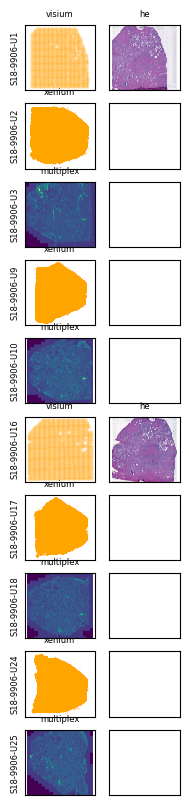

In [262]:
bigwarp.display_data_map(data_map, multiplex_channel=multiplex_channel, gamma=.5)

## Writing un-registered images for keypoint registration with BigWarp

In [282]:
output_dir = os.path.join(reg_dir, 'unregistered_tifs') # where to write un-registered images to use with bigwarp
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [283]:
# scale factors for registration
# each data type identifier will be downsampled by {default_scale}, or scale specified in {dtype_to_scale} (bigwarp registration can be cumbersome with large, full resolution images)
# this scale factor DOES NOT downsample data input to mushroom, mushroom inputs will still be full resolution. It is purely to get bigwarp to run more smoothly.
# here we just downsample every data type by 20%
default_scale = .2

# if you wanted a specific data type to be scaled more or less than other data types, you could specify here
dtype_to_scale = {
#     'multiplex': .1, # for example, if you uncommented this line multiplex data would be scaled by .1 instead of .2
}

In [304]:
# image saving for each data type

def write_st(filepath, output_filepath, dtype, scale=.1):
    if dtype == 'visium':
        adata = visium.adata_from_visium(filepath)
    elif dtype == 'xenium':
        adata = xenium.adata_from_xenium(filepath)
    elif dtype == 'cosmx':
        adata = cosmx.adata_from_cosmx(filepath)
    else:
        raise RuntimeError(f'{dtype} not valid st data type')

    image_data = next(iter(adata.uns['spatial'].values()))
    
    img = image_data['images']['hires'] # grab image
    
    # need to adjust scale by tissue_hires_scalef because spot/cell coordinates are at a different resolution than the image
    sf = scale / image_data['scalefactors']['tissue_hires_scalef']
    
    dim_order = 'h w' if dtype in ['xenium', 'cosmx'] else 'h w c'
    he = utils.rescale(img, scale=sf, dim_order=dim_order) # scale image
    
    tifffile.imwrite(output_filepath, he, compression='LZW') # write scaled H&E


def write_multiplex(filepath, output_filepath, channel='DAPI', scale=.1):
    # extract OME-TIF
    channel_to_img = multiplex.extract_ome_tiff(
        filepath, channels=[channel], scale=scale
    )
    
    # conversion to uint8
    img = channel_to_img[channel]
    if img.dtype != np.uint8:
        img /= img.max() # just use max intensity bc not sure what data type range we'll be dealing with
        img *= 255.
        img = img.astype(np.uint8)

    tifffile.imwrite(output_filepath, img, compression='LZW')
    

def write_he(filepath, output_filepath, scale=.1):
    img = he.read_he(filepath, scale=scale)

    tifffile.imwrite(output_filepath, img, compression='LZW')

In [306]:
for idx, item in enumerate(data_map['sections']):
    sid = item['sid']
    mapping = item['data'][0] # use first data type for registration by default
    dtype, filepath = mapping['dtype'], mapping['filepath']
    print(sid, dtype)

    output_filepath = os.path.join(output_dir, f's{idx}_{sid}.tif')

    scale = dtype_to_scale.get(dtype, default_scale)
    if utils.parse_dtype(dtype) in ['visium', 'cosmx', 'xenium']:
        write_st(filepath, output_filepath, dtype, scale=scale)
    elif utils.parse_dtype(dtype) == 'multiplex':
        write_multiplex(filepath, output_filepath, channel=multiplex_channel, scale=scale)
    elif utils.parse_dtype(dtype) == 'he':
        write_he(filepath, output_filepath, scale=scale)
    else:
        raise RuntimeError(f'{dtype} is not a valid data type identifier')

S18-9906-U1 visium


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


S18-9906-U2 xenium


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


S18-9906-U3 multiplex
S18-9906-U9 xenium


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


S18-9906-U10 multiplex
S18-9906-U16 visium


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


S18-9906-U17 xenium


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


S18-9906-U18 multiplex
S18-9906-U24 xenium


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


S18-9906-U25 multiplex


Unregistered images should now be written to output_dir (see cell below)

Each image has the following format: "s{idx}_{section_id}" where idx is the position of the section and section_id is the section id given in the data map

In [ ]:
sorted(utils.listfiles(output_dir))

## Registration with BigWarp

See here []() for a video on how to register the images saved in the above section.

In short, we need to export a warp field from BigWarp for each section. These warp fields are then used in the next section to register full resolution data for each section

## Registration of full-resolution data for each section

We should now have a directory of files named in the following format:

"s{idx}_{section_id}_ddf.tif" where idx is the section index and section_id is the section identifier

These files are warp fields (dense-displacement fields) that specify how to align each image section

There should be one less file than number of sections (there is no warp field for the initial section used as the fixed image, as that image is what all other images are being aligned to). In this case, that is the second section (s1_S18-9906-U2) in the experiment.

In [290]:
registered_dir = os.path.join(run_dir, 'registered') # this is where we will put our registered data for each section
Path(registered_dir).mkdir(parents=True, exist_ok=True)

In [291]:
fps = sorted(utils.listfiles(reg_dir, regex=r'ddf.tif$'))
fps

['/diskmnt/Projects/Users/estorrs/mushroom/data/projects/examples/full_workflow/registration/s0_S18-9906-U1_ddf.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/examples/full_workflow/registration/s2_S18-9906-U3_ddf.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/examples/full_workflow/registration/s3_S18-9906-U9_ddf.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/examples/full_workflow/registration/s4_S18-9906-U10_ddf.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/examples/full_workflow/registration/s5_S18-9906-U16_ddf.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/examples/full_workflow/registration/s6_S18-9906-U17_ddf.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/examples/full_workflow/registration/s7_S18-9906-U18_ddf.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/projects/examples/full_workflow/registration/s8_S18-9906-U24_ddf.tif',
 '/diskmnt/Projects/Users/estorrs/mushroom/data/pro

read in warp fields

In [293]:
target_sid = data_map['target_sid']

sid_to_ddf = {}

for idx, item in enumerate(data_map['sections']):
    sid = item['sid']
    mapping = item['data'][0]
    dtype, filepath = mapping['dtype'], mapping['filepath']
    scale = dtype_to_scale.get(dtype, default_scale)
    
    if sid != target_sid: # initial registration target section will not have ddf
        ddf_fp = os.path.join(reg_dir, f's{idx}_{sid}_ddf.tif')

        assert os.path.exists(ddf_fp), f'Expected a warp field file at {ddf_fp}, but no file was found.'
        ddf = bigwarp.read_bigwarp_warp_field(ddf_fp, scale) # ddfs are (c h w)
        sid_to_ddf[sid] = ddf

sid_to_ddf.keys()

dict_keys(['S18-9906-U1', 'S18-9906-U3', 'S18-9906-U9', 'S18-9906-U10', 'S18-9906-U16', 'S18-9906-U17', 'S18-9906-U18', 'S18-9906-U24', 'S18-9906-U25'])

In [303]:
img = tifffile.imread('/diskmnt/Projects/Users/estorrs/sandbox/S18-9906_U1_tmp.tif')
img.shape

(19613, 19367, 3)

apply warp fields to each section and data type

In [307]:
registered_data_map = copy.deepcopy(data_map)

res = data_map['resolution']

for idx, item in enumerate(data_map['sections']):
    sid = item['sid']
    for m_idx, mapping in enumerate(item['data']):
        dtype, fp = mapping['dtype'], mapping['filepath']
        print(sid, dtype, fp)
        
        dtype_root = utils.parse_dtype(dtype)
        section_id = f's{idx}_{sid}'
        ddf = sid_to_ddf.get(sid)
        
        if dtype_root == 'he':
            img = he.read_he(fp)
            img = rearrange(img, 'h w c -> c h w') # channel dim must be first
#             print(img.shape, ddf.shape)

            if ddf is not None:
                img = bigwarp.register_he(img, ddf)

            output_filepath = os.path.join(registered_dir, f'{section_id}_{dtype}.tif')
            tifffile.imwrite(
                output_filepath,
                data=rearrange(img, 'c h w -> h w c'),
                resolution=(res, res),
                compression='LZW',
                metadata={
                    'axes': 'YXC',
                    'unit': 'um', # assumes microns as unit
                }
            )
        elif dtype_root == 'visium':
            adata = visium.adata_from_visium(fp)

            if ddf is not None:
                adata = bigwarp.register_visium(
                    adata, ddf, resolution=res
                )
            output_filepath = os.path.join(registered_dir, f'{section_id}_{dtype}.h5ad')
            adata.write_h5ad(output_filepath)
        elif dtype_root == 'xenium':
            adata = xenium.adata_from_xenium(fp)
            if ddf is not None:
                adata = bigwarp.register_xenium(
                    adata, ddf, resolution=res
                )
            output_filepath = os.path.join(registered_dir, f'{section_id}_{dtype}.h5ad')
            adata.write_h5ad(output_filepath)
        elif dtype_root == 'cosmx':
            adata = cosmx.adata_from_cosmx(fp)
            if ddf is not None:
                adata = bigwarp.register_cosmx(
                    adata, ddf, resolution=res
                )
            output_filepath = os.path.join(registered_dir, f'{section_id}_{dtype}.h5ad')
            adata.write_h5ad(output_filepath)
        elif dtype_root == 'multiplex':
            channels, data = multiplex.extract_ome_tiff(fp, as_dict=False)
            if ddf is not None:
                data = bigwarp.register_multiplex(data, ddf)
            output_filepath = os.path.join(registered_dir, f'{section_id}_{dtype}.ome.tiff')
            multiplex.write_basic_ome_tiff(
                output_filepath,
                data, channels, pix_per_micron=res
            )
        
        registered_data_map['sections'][idx]['data'][m_idx]['filepath'] = output_filepath

S18-9906-U1 visium /diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/S18-9906/B27Us1_1/S18-9906-B27Us1_1Bp1/outs


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versio

S18-9906-U1 he /diskmnt/Projects/Users/estorrs/sandbox/S18-9906_U1_tmp.tif
S18-9906-U2 xenium /diskmnt/primary/Xenium/data/20230912__220334__24002/output-XETG00122__0010784__S18-9906-B27Us1_2Q1__20230912__220421


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


S18-9906-U3 multiplex /diskmnt/primary/CODEX/HTAN/20231006_Prostate_Serial_S18-9906_slide_3/S18-9906-U3__20231006.ome.tiff
S18-9906-U9 xenium /diskmnt/primary/Xenium/data/20230912__220334__24002/output-XETG00122__0010787__S18-9906-B27Us1_9Q1__20230912__220421


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


S18-9906-U10 multiplex /diskmnt/primary/CODEX/HTAN/20231006_Prostate_Serial_S18-9906_slide_3/S18-9906-U10__20231006.ome.tiff
S18-9906-U16 visium /diskmnt/Datasets/Spatial_Transcriptomics/outputs_FFPE/Human/S18-9906/B27Us1_16/S18-9906-B27Us1_16Bp1/outs


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future versio

S18-9906-U16 he /diskmnt/Projects/Users/estorrs/sandbox/S18-9906_U16_tmp.tif
S18-9906-U17 xenium /diskmnt/primary/Xenium/data/20230912__220334__24002/output-XETG00122__0010784__S18-9906-B27Us1_17Q1__20230912__220421


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


S18-9906-U18 multiplex /diskmnt/primary/CODEX/HTAN/20231006_Prostate_Serial_S18-9906_slide_3/S18-9906-U18__20231006.ome.tiff
S18-9906-U24 xenium /diskmnt/primary/Xenium/data/20230912__220334__24002/output-XETG00122__0010787__S18-9906-B27Us1_24Q1__20230912__220421


/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):
/diskmnt/Projects/Users/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/anndata/_core/anndata.py:1113: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(df_full[k]):


S18-9906-U25 multiplex /diskmnt/primary/CODEX/HTAN/20231006_Prostate_Serial_S18-9906_slide_3/S18-9906-U25__20231006.ome.tiff


S18-9906-U1 visium
S18-9906-U1 he
S18-9906-U2 xenium
S18-9906-U3 multiplex
S18-9906-U9 xenium
S18-9906-U10 multiplex
S18-9906-U16 visium
S18-9906-U16 he
S18-9906-U17 xenium
S18-9906-U18 multiplex
S18-9906-U24 xenium
S18-9906-U25 multiplex


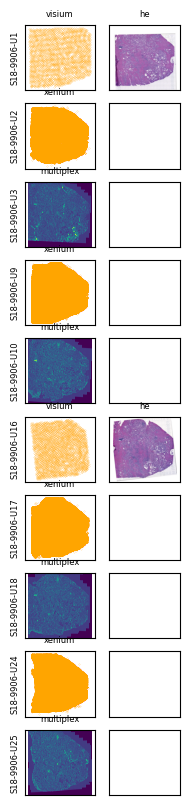

In [309]:
bigwarp.display_data_map(registered_data_map, multiplex_channel=multiplex_channel, gamma=.5)

## save registration metadata

registered_data_map already has all the data mushroom needs, so we just need to save it

In [ ]:
yaml.safe_dump(registered_data_map, open(os.path.join(registered_dir, 'metadata.yaml'), 'w'))

In [310]:
# just viewing
yaml.safe_dump(registered_data_map, sys.stdout)

resolution: 1.0
sections:
- data:
  - dtype: visium
    filepath: /diskmnt/Projects/Users/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_visium.h5ad
  - dtype: he
    filepath: /diskmnt/Projects/Users/estorrs/mushroom/data/projects/examples/full_workflow/registered/s0_S18-9906-U1_he.tif
  position: 0
  sid: S18-9906-U1
- data:
  - dtype: xenium
    filepath: /diskmnt/Projects/Users/estorrs/mushroom/data/projects/examples/full_workflow/registered/s1_S18-9906-U2_xenium.h5ad
  position: 5
  sid: S18-9906-U2
- data:
  - dtype: multiplex
    filepath: /diskmnt/Projects/Users/estorrs/mushroom/data/projects/examples/full_workflow/registered/s2_S18-9906-U3_multiplex.ome.tiff
  position: 10
  sid: S18-9906-U3
- data:
  - dtype: xenium
    filepath: /diskmnt/Projects/Users/estorrs/mushroom/data/projects/examples/full_workflow/registered/s3_S18-9906-U9_xenium.h5ad
  position: 40
  sid: S18-9906-U9
- data:
  - dtype: multiplex
    filepath: /diskmnt/Projects/Users/